<a href="https://colab.research.google.com/github/yaroslav711/ml_spring2021/blob/main/Task3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML T-Generation Занятие 3: Линейная регрессия.
# Проблема переобучения. Кросс-валидация и регуляризация.

Авторы: Гаркавый Андрей (andrewgarkavyy@gmail.com), Кирилл Васильев (kirivasile@yandex.ru)


## 0. План

1. Приближение одномерной функции многочленом

2. Переобучение

3. Выводы

4. Разделение на тренировочную и тестовую части

5. Кросс-валидация

6. Линейная регрессия

7. Как подбираются коэффициенты

8. Регуляризация

## 1. Приближение одномерной функции многочленом

Начнем с простой задачи.


1) Есть функция $f(x)$, но мы ее не знаем.

2) Зато мы знаем ее значения в $m$ точках (они называются тренировочным множеством):
$$f(x_1) = y_1$$
$$\cdots$$
$$f(x_m) = y_m$$
3) Нужно научиться приблизительно восстанавливать эту функцию.

Самый простой способ - научиться приближать её многочленом, а именно давайте подберем такие коэффициенты $a_0, a_1, \ldots, a_n$, чтобы многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$ был как можно ближе к $f(x)$.

Но что такое "приблизить"? Мы знаем лишь значения в $m$ точках, так что в лучшем случае она должна проходить через все эти точки (хотя скоро мы увидим, что это не так).

В этом случае обычно пытаются минимизировать сумму квадратов ошибок во всех точках, то есть **функцию потерь** $$L(P) = \sum_i (P(x_i) - f(x_i))^2 $$

Эту величину называют **MSE** - Mean Squared Error (средняя квадратичная ошибка).

Тут может возникнуть вопрос, почему мы берем именно сумму квадратов, а не, например, сумму модулей. Однозначного ответа на этот вопрос нет, наиболее удачный ответ, пожалуй такой: у суммы квадратов есть много удобных свойств, например это выпуклая, дифференцируемая функция. Тем не менее иногда другой выбор может быть оправданным. Если вам интересно чуть больше понять про смысл этих условий, можете решить такие задачи:

**(0.5 балла) Доп. Задача 1.** Найдите число m такое, что для заданных $x_i$ сумма $\sum|m - x_i|$ минимальна

<Место для решения>

**(0.5 балла) Доп. Задача 2.** Найдите число m такое, что для заданных $x_i$ сумма $\sum(m - x_i)^2$ минимальна


<место для решения>

Сейчас можно их и пропустить.


В питоне есть пакет scipy, в котором как раз есть решение этой задаче - подбор такого многочлена для заданных точек, что среднеквадратичная ошибка минимальна.

Чтобы им пользоваться, вам нужно ввести в консоли Анаконды `conda install scipy`. Или, если вы настроили pip `pip install scipy`

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import pyplot as plt

Сначала просто нарисуем какой-нибудь многочлен, например $f(x) = 3x^3 - 2x^2 + x$ на отрезке $[-1, 1]$:

In [ ]:
def f(x):
    return 3 * x ** 3 - 2 * x**2 + x

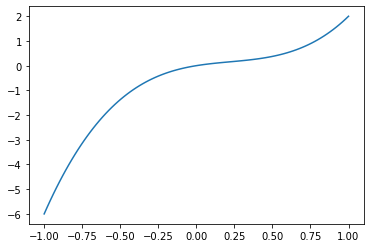

In [ ]:
x100 = np.linspace(-1, 1, 100)
plt.plot(x100, f(x100))

Теперь зададим набор точек (10 штук) и посмотрим что будет, если подобрать по ним коэффициенты нашего многочлена:

In [ ]:
x = np.linspace(-1, 1, 10)  # 10 точек на отрезке [-1, 1]
y = f(x)
coefs = np.polyfit(x, y, deg = 2)
coefs

array([-2.00000000e+00,  3.17037037e+00, -5.61733355e-16])

(это означает многочлен $-2x^2 + 3.17037 x$)

scipy позволяет легко работать с многочленами, заданными их коэффициентами. Мы можем создать из них объект poly1d, который можно будет просто вызывать для получения нужных значений:

In [ ]:
poly = np.poly1d(coefs)
poly(0), poly(1), poly(2)

(-5.617333549722722e-16, 1.1703703703703718, -1.6592592592592543)

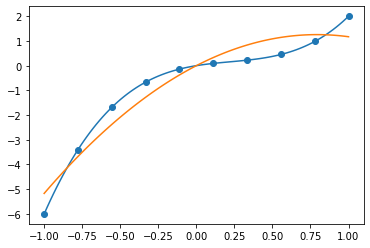

In [ ]:
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))

Довольно ожидаемо, наша функция (оранжевая) не очень похожа на то, что мы искали (синяя). Наверное зря мы пытаемся приблизить кубическую функцию многочленом второй степени. Давайте попробуем 3-ю степень.

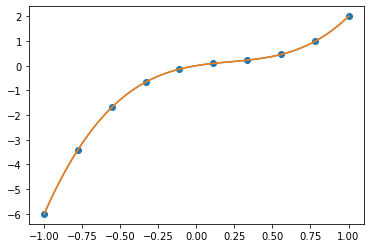

In [ ]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))

На этот раз мы в точности угадали функцию. Можете проверить, что если увеличивать степень многочлена, результат не меняется: более высокие степени тут просто не нужны.

Но мы сейчас жили в идеальном мире. На практике чаще всего известные нам значения не совсем точны. Давайте добавим к значениям нашей функции немного шума:

In [ ]:
np.random.seed(42)
x = np.linspace(-1, 1, 10)
y = f(x) + np.random.normal(0, 0.5, 10)  # случайный шум

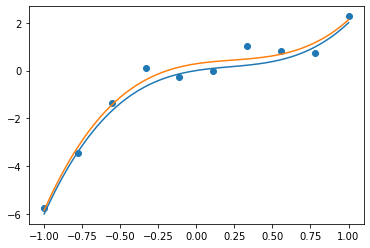

In [ ]:
coefs = np.polyfit(x, y, deg = 3)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))

Теперь мы почти попали. Перед тем как читать дальше, подумайте над заданием.

**(1 балл) Обязательное задание 1:** попробуйте увеличить степень полинома. Что произойдет с графиком нашего приближения? Посмотрите  как обе функции себя ведут вне интервала x. Попробуйте сформулировать проблему, с которой мы столкнулись.

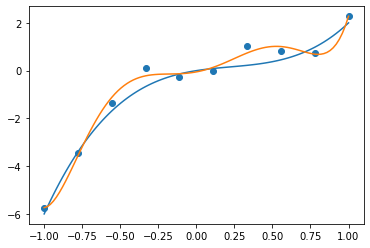

In [ ]:
# Место для решения
coefs = np.polyfit(x, y, deg = 6)
poly = np.poly1d(coefs)
plt.scatter(x, y)
plt.plot(x100, f(x100))
plt.plot(x100, poly(x100))

    Полученная функция проходит через заданные точки с меньшей среднеквадратичной ошибкой, но все меньше совпадает с искомой функцией 3 степени

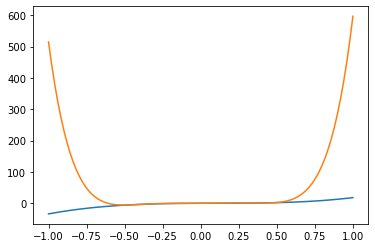

In [ ]:
plt.plot(x100, f(np.linspace(-2, 2, 100)))
plt.plot(x100, poly(np.linspace(-2, 2, 100)))

Найденная функция хорошо проходит через заданные точки обучающей выборки, но имеет мало общего с реальной заданной функцией, которую мы стремимся получить

То, что вы увидели при решении этого задания называется в машинном обучении **переобучением** (overfittig).

Если мы используем достаточно сложную модель (то есть модель, у которой много параметров, в нашем случае -- многочлен достаточно высокой степени), то у модели появляется возможность "выучить" все точки, которые она видела. Например, если задано $m$ точек, всегда можно подобрать многочлен степени $m-1$, который через них проходит (если вы не знакомы с этим фактом, можете подумать, как его доказать).


## 2. Переобучение

"Честный" способ проверять качество нашей апроксимации -- **смотреть точность в точках, которые мы не использовали при подборе многочлена**. Это множество часто называют тестовым множеством. Давайте зададим его так:

In [ ]:
np.random.seed(42)
# возьмем 10 случайных точек от 0 до 1
x_test = np.random.random(10) 

# превратим их в 10 случайных точек от -1 до 1
x_test = 2 * x_test - 1
x_test

array([-0.25091976,  0.90142861,  0.46398788,  0.19731697, -0.68796272,
       -0.68801096, -0.88383278,  0.73235229,  0.20223002,  0.41614516])

**(1 балл)  Обязательное задание 2:** напишите функцию, которая для данного многочлена считает его качество на тестовом множестве (то есть среднеквадратичное отклонение между значениями функции $f$ и многочлена $P$ на тестовой выборке).

Вы все прошлое занятие изучали разные функции, попробуйте сделать MSE как можно более компактной функцией (желательно в одну строчку).

In [ ]:
# y_real - это np.array c реальными значениями в точках
# y_pred - это np.array c предсказанными нами значениями в точках
# они одной длины
def MSE(y_real, y_pred):
    return (((y_real - y_pred)**2).sum())/(len(y_pred))
 

**(1 балл) Обязательное задание 3:** нарисуйте график зависимости ошибки на тестовом множестве от степени многочлена. При какой степени ошибка минимальна?


лучший результат при deg = 4


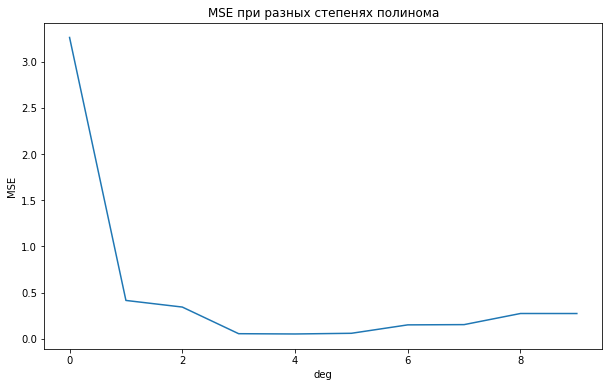

In [ ]:
mse = []
for i in range(10):
    coefs = np.polyfit(x, y, deg = i)
    poly = np.poly1d(coefs)
    mse.append(MSE(f(x_test), poly(x_test)))

#result
print(f'лучший результат при deg = {np.array(mse).argmin()}')

#plot diagram
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 9, 10), mse)
plt.title('MSE при разных степенях полинома')
plt.ylabel('MSE')
plt.xlabel('deg')
plt.show()

**(1 балл) Доп. задача 5:** как меняется график, если увеличивать количество точек в множестве, на котором мы подбираем многочлен?

лучший результат при deg = 3


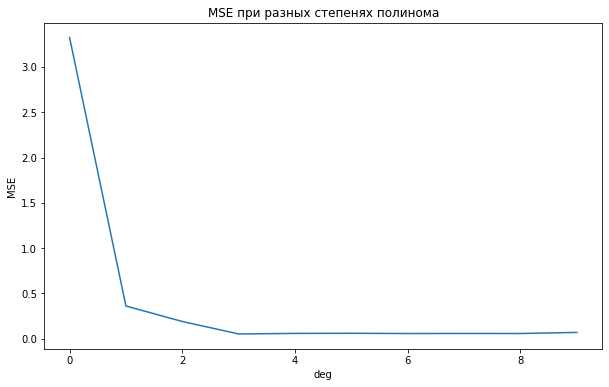

In [ ]:
# место для решения
x_new = np.linspace(-1, 1, 20)
y_new = f(x_new) + np.random.normal(0, 0.5, 20)
mse = []
for i in range(10):
    coefs = np.polyfit(x_new, y_new, deg = i)
    poly = np.poly1d(coefs)
    mse.append(MSE(f(x_test), poly(x_test)))

#result
print(f'лучший результат при deg = {np.array(mse).argmin()}')

#plot diagram
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(0, 9, 10), mse)
plt.title('MSE при разных степенях полинома')
plt.ylabel('MSE')
plt.xlabel('deg')
plt.show()

При увеличении объема обучающей выборки мы видим, что эффект переобучения менее выражен.

## 3. Выводы

1) Цель машинного обучения с учителем - приблизить **целевую функцию** (target) по её значениям (возможно приблзительным) в некоторых точках.

В нашем случае - это $f(x) = 3x^3 - 2x^2 + x$. Обычно она, конечно, никому неизвестна.

2) Множество точек с известным значением функции называется **тренировочным множеством** (train).

В нашем случае - это 10 точек, выбранных равномерно на отрезке $[-1, 1]$.

3) Чтобы приблизить функцию, нужно использовать какую-то **модель** (model), приближающую функцию.

В данном случае - это многочлен $P(x) = a_0 + a_1x + a_2x^2 + \ldots + a_nx^n$.

4) Мы выбираем **функцию потерь** (loss function) для сравнения результатов модели и реальных значения на тренировочном множестве. Чем она меньше, тем лучше наша модель.

В данном случае - это $MSE = \sum_i (P(x_i) - f(x_i))^2$.

5) У модели есть **параметры**, которые мы выбираем так, чтобы функция потерь на тренировочном множестве была минимальна.

В данном случае - это коэффициенты многочлена ($a_0, a_1, \ldots, a_n$). Выбираются они с помощью пока магической для нас функции polyfit.

6) У модели есть **гиперпараметры**, которые мы выбираем сами.

В данном случае - это степень многочлена (число $n$).

7) Однако такой подход с минимизацией функции потерь может привести к тому, что мы идеально приблизим функцию на тренировочном множестве, но она будет абсолютно отличаться во всех остальных точках. Это явление называется **переобучением**.

В данном случае - мы видели, что если степень многочлена большая (больше трех), то мы попадаем во все точки, но при этом сам многочлен сильно отличается от $f(x)$.

8) Чтобы бороться с переобучением, полезно выделить **тестовое множество** точек, в которых мы тоже знаем результаты функции. Оно никак не используется при обучении модели, и нужно только для валидации результата.

В данном случае - мы взяли рандомные 10 точек на отрезке $[-1, 1]$.

9) В идеальном случае функция потерь на тренировочном и тестовом множестве не отличается. А вот если на тренировочном функция потерь получается гораздо меньше, чем на тестовом, то это говорит о том, что происходит переобучение.

Действительно, при большой степени MSE близка к или равна нулю на тренировочном множестве, а на тестовом множестве нет.

10) Единственный пока способ, который мы знаем, чтобы влиять на переобучение - это перебирать **гиперпараметры** модели так, чтобы **минимизировать функцию потерь на тестовом множестве**.

Действительно, если выбрать степень 3, то функция потерь окажется минимальной на тестовом множестве, как мы видели в задании 3.

## 4. Разделение на тренировочную и тестовую части

Если вы решите поучаствовать в каком-нибудь соревновании по машинному обучению, вы увидите, что тестовое множество вам недоступно (иначе было бы неинтересно: очень легко обучиться предсказывать то, что ты уже видел).

В реальной жизни обычно тоже считают, что на тестовом множестве можно провериться один раз -- в самом конце. Иначе вы начнете подкручивать гиперпараметры глядя на результат на тестовой выборке и, сами того не замечая, переобучитесь.

Как поступать в такой ситуации? Придется пожертвовать частью точек, которые даны нам для обучения и использовать их для подбора гиперпараметров в нашем алгоритме (в нашем случае это степень многочлена).

То есть придется из точек, у которых мы знаем результаты, убрать, например, 10% в тестовое множество.

Функция для этого есть, например, в пакете sklearn, который можно скачать так: `pip install scikit-learn` (`conda install scikit-learn`)

In [ ]:
X = np.linspace(-1, 1, 50)
y = f(X)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
X_train, y_train

(array([ 0.06122449,  0.59183673,  0.67346939, -0.59183673,  0.79591837,
        -0.06122449,  0.42857143, -0.18367347,  0.87755102, -0.51020408,
        -0.83673469, -0.26530612,  0.14285714,  1.        , -0.42857143,
        -0.3877551 ,  0.46938776,  0.18367347,  0.2244898 ,  0.34693878,
        -0.55102041,  0.75510204,  0.95918367,  0.26530612,  0.51020408,
        -0.63265306, -0.14285714, -0.79591837,  0.71428571,  0.91836735,
        -0.34693878,  0.83673469,  0.3877551 , -0.71428571, -0.75510204,
         0.10204082, -0.2244898 , -0.95918367,  0.02040816, -0.67346939,
        -0.46938776, -0.02040816, -0.87755102, -0.30612245,  0.55102041]),
 array([ 0.0544161 ,  0.51320453,  0.68272574, -1.91428741,  1.04155581,
        -0.06940985,  0.29737609, -0.26973455,  1.36475448, -1.42925142,
        -3.99444109, -0.46210338,  0.11078717,  2.        , -1.03206997,
        -0.86336475,  0.33899141,  0.13479078,  0.1576384 ,  0.23148518,
        -1.66017561,  0.90637404,  1.76655985,  0

In [ ]:
X_test, y_test

(array([ 0.63265306, -0.10204082, -0.91836735,  0.30612245, -1.        ]),
 array([ 0.59181124, -0.12605292, -4.92881367,  0.20476162, -6.        ]))

## 5. Кросс-валидация

Также есть более точный способ проводить валидацию результата. Если разделить множество один раз на тестовое и тренировочное, то это может значительно влиять на результат. Вдруг в тестовое множество случайно попали такие точки, в которых предсказать значение тяжелее или легче, чем обычно?

Тогда можно применить **кросс-валидацию** - давайте разделим множество на 10 примерно равных частей, тогда у нас есть 10 разделений на тренировочное и тестовое множество - как тестовое множество выберем по очереди каждую из этих частей, а как тренировочное выберем все остальные части. В итоге, все элементы множества побывают и в тренировочной, и в тестовой чати.

Можно посчитать результат на каждом из 10 разбиений и просто усреднить результат.


In [ ]:
# Есть вот такая удобная штука
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(X)
for train_index, test_index in kf.split(X):
    print(test_index, train_index)

[0 1 2 3 4] [ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[5 6 7 8 9] [ 0  1  2  3  4 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[10 11 12 13 14] [ 0  1  2  3  4  5  6  7  8  9 15 16 17 18 19 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[15 16 17 18 19] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[20 21 22 23 24] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[25 26 27 28 29] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49]
[30 31 32 33 34] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20

**(1 балл) Доп. задача 6:** проделайте все вышеописанное с функцией $f(x) = \frac{1}{1 + e^{-x}}$ на отрезке $[-3, 3]$. Как оптимальная степень зависит от количества точек, по которым вы подбираете многочлен?

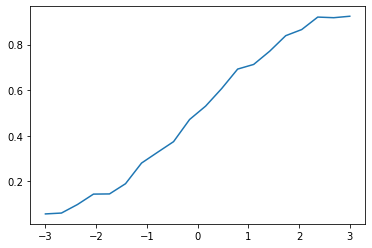

In [ ]:
np.random.seed(42)
def f(x):
    return 1/(1+np.exp(-x))
x = np.linspace(-3, 3, 20)
y = f(x) + np.random.normal(0, 0.02, 20)
plt.plot(x, y)

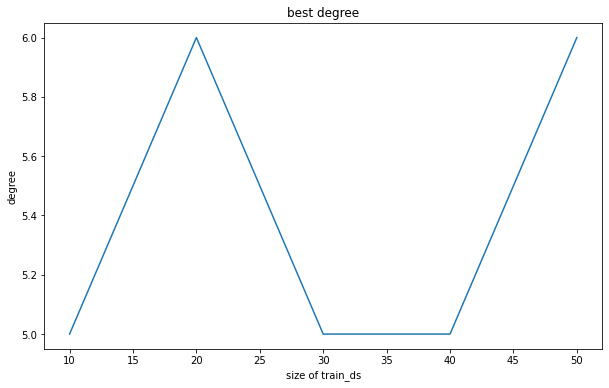

In [ ]:
np.random.seed(42)
x_test = np.random.random(10) 

# превратим их в 10 случайных точек от -3 до 3
x_test = 6 * x_test - 3


# место для решения

degrees = []
for j in range(10, 51, 10):
    x = np.linspace(-3, 3, j)
    y = f(x) + np.random.normal(0, 0.02, j)
    mse = []
    for i in range(10):
        coefs = np.polyfit(x, y, deg = i)
        poly = np.poly1d(coefs)
        mse.append(MSE(f(x_test), poly(x_test)))
    degrees.append(np.array(mse).argmin())


#plot diagram
plt.figure(figsize=(10, 6))
plt.plot(np.linspace(10, 50, 5), degrees)
plt.title('best degree')
plt.ylabel('degree')
plt.xlabel('size of train_ds')
plt.show()

## 6. Линейная регрессия

**Регрессией** называется задача машинного обучения с учителем, в которой у нас есть много объектов с признаками, у которых надо научиться приближенно предсказывать значение целевой функции, которая равна какому-то **действительному числу**. 

В этом будет отличие задачи регрессии от задачи классификации - регрессия предсказывает число, а классификация - один из нескольких классов.

До этого мы учились приближать одномерную функцию многочленом. Каждая точка имела ровно один признак - коодинату $x$.

Тем не менее, чаще всего в машинном обучении признаков гораздо больше. Возьмем какой-нибудь реальный датасет.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

data = pd.read_csv('Advertising.csv', index_col=0)
data.head()

TV  Radio  Newspaper  Sales
1  230.1   37.8       69.2   22.1
2   44.5   39.3       45.1   10.4
3   17.2   45.9       69.3    9.3
4  151.5   41.3       58.5   18.5
5  180.8   10.8       58.4   12.9

В датасете показаны результаты продаж разных товаров в зависимости от ресурсов (тысяч долларов), которые вложили в различные средства распространения информации:
* TV - реклама по телевизору
* radio - на радио
* newspapers - в газетах

Целевая переменная:

sales - продажи такого-то товара (тысячи штук)

In [ ]:
# Размеры датасета
data.shape

(200, 4)

Признаков немного, поэтому давайте попробуем визуализиовать зависимость целевой переменной от каждого из признаков.

<AxesSubplot:xlabel='Newspaper', ylabel='Sales'>

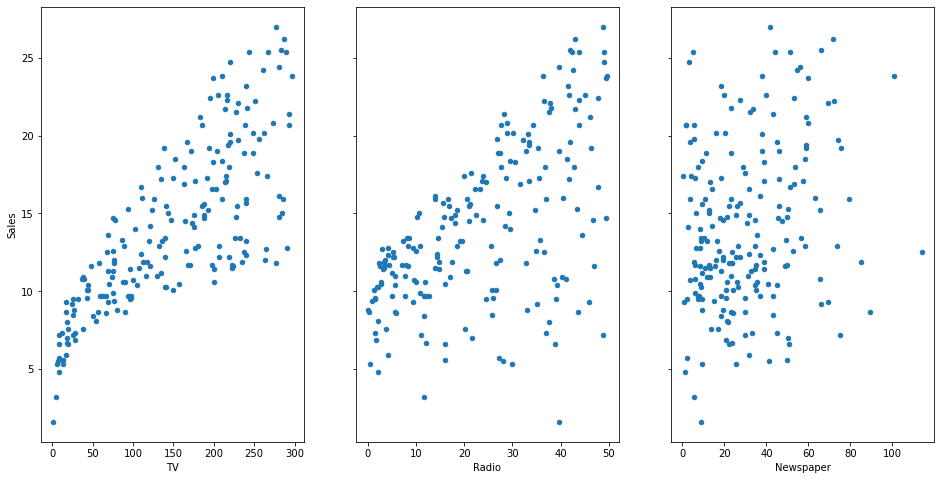

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True)
data.plot(kind='scatter', x='TV', y='Sales', ax=axs[0], figsize=(16, 8))
data.plot(kind='scatter', x='Radio', y='Sales', ax=axs[1])
data.plot(kind='scatter', x='Newspaper', y='Sales', ax=axs[2])

### Простая линейная регрессия

Из графиков выше предположим, что только размер рекламы на телевизоре влияет на продажи больше всего. Формула для такого случая выглядит следующим образом:
$$y=\beta_0+\beta_1x$$
Здесь:
* $y$ - наше предсказание продаж
* $x$ - сколько денег вложили в рекламу по телевидению
* $\beta_0$ - сдвиг
* $\beta_1$ - параметр, отвечающий за важность признака x

$\beta_0$ и $\beta_1$ - это параметры нашей модели. Чтобы создать хорошую модель, надо "обучить" эти значения. Т.е. изменить их так, чтобы они хорошо работали для нашей задачи.

### Обучение коэффициентов модели

Параметры $\beta_0$ и $\beta_1$ подбираются таким образом, чтобы минимизировать **сумму наименьших квадратов ошибок**:

$$L(MSE)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

<img src="mse_plot.png">

* Чёрные точки на даграмме $y^{true}$ - это полученные истинные значения x и y .
* Синяя линия $y^{pred}$ - это наша модель: линия, которой мы стараемся приблизить данные .
* Красные отрезки - это ошибки нашей модели.


Как коэффициенты $\beta_0$ и $\beta_1$ соотносятся с синей линией:
* $\beta_0$ - это сдвиг нашей прямой, т.е. значение y при x = 0.
* $\beta_1$ - это тангенс угла наклона прямой.

Как искать данные коэффициенты? Есть много техник: аналитическое решение, методы основанные на градиентном спуске. Пока же достаточно знать, что многие библиотеки (в том числе и sklearn) умеют это делать. Зачем кожаному мешку напрягаться :)

In [ ]:
from sklearn.linear_model import LinearRegression

# Наша модель
reg = LinearRegression()

# Подготовим данные для неё
# На вход требуется 2D матрица, а у нас только один признак,
# и надо превратить его из 1D вектора (n,) в 2D матрицу (n, 1).
# Это можно сделать с помощью метода reshape
x = data["TV"].values.reshape(-1, 1) 
y = data["Sales"].values

# Обучаем нашу модель
reg.fit(x, y)

# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
print("Массив коэффициентов={}".format(reg.coef_))

Сдвиг=7.032593549127693
Массив коэффициентов=[0.04753664]


### Интерпретируем коэффициенты
Что означает коэффициент, связанный с телевидением ($\beta_1$)?
* Дополнительные 1000$, вложенные на в рекламу на телевидении, позволят продажам товара вырасти где-то на 0.047 * 1000 = 47 тысяч единиц.

In [ ]:
# Посчитаем ручками
7.032594 + 0.047537*50

9.409444

In [ ]:
X_new = pd.DataFrame({'TV': [50]})
X_new.head()

TV
0  50

In [ ]:
reg.predict(X_new)

array([9.40942557])

### Нарисуем нашу прямую

In [ ]:
# Возьмём предсказания для данных, на которых обучались
y_pred = reg.predict(x)
y_pred.shape

(200,)

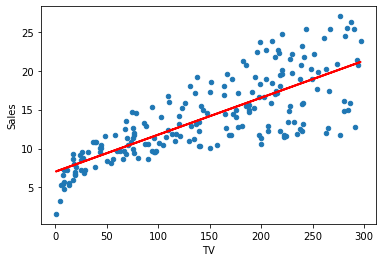

In [ ]:
# Сначала выведем истинные данные
data.plot(kind='scatter', x='TV', y='Sales')

# Теперь рисуем нашу линию
plt.plot(x, y_pred, c='red', linewidth=2)

Посчитаем ошибку MSE на обучающей выборке:


In [ ]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_pred, y))

10.512652915656757


### Используем все признаки

Простую линейную регрессию с одним признаком можно легко расширить на случай нескольких признаков:
$$y=\beta_0+\beta_1x_1+...+\beta_nx_n$$

А для нашего датасета это будет выглядеть так:
$$Sales=\beta_0+\beta_1*TV+\beta_2*radio+\beta_3*newspaper$$

Давайте опять воспользуемся sklearn, чтобы их оценить:

In [ ]:
reg = LinearRegression()

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Обучаем нашу модель
reg.fit(X, y)

# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {}={}".format(column, coef))

Сдвиг=2.9388893694594085
Коэффициент для TV=0.045764645455397615
Коэффициент для Radio=0.18853001691820448
Коэффициент для Newspaper=-0.0010374930424763007


Вес признака отвечает также, как и в предыдущем случае за значимость этого признака. Для газет он вообще отрицательный. Вычислим ошибку на обучающей выборке.

In [ ]:
y_pred = reg.predict(X)

# Ошибка теперь равна:
print(mean_squared_error(y_pred, y))

2.784126314510936


Ошибка уже меньше, чем при одном признаке, однако измерять ошибку на обучающей выборке неправильно. Помимо истинной зависимости между признаками и целевой переменной, туда могут затесаться случайности, лишние данные и прочие факторы. Если не ограничивать каким-то образом модель (об этом мы узнаем позднее), то модель легко подстраивается под эти шумы. Она начинает показывать очень хорошее качество на обучающей выборке, но когда мы попробуем посмотреть качество на других выборках, то там модель будет показывать себя плохо. Это и есть переобучение.

<img src="overfit.png">

Поэтому применим кросс-валидацию:

In [ ]:
# Многие выбирают k=5 для начала
k = 5
errors = []

X = data.drop("Sales", axis=1)
y = data["Sales"]

# Размер одной части
fold_size = len(X) // k

# Мб этот код на семинаре написать?
for i in range(k):
    # Берём все значения, кроме выбранной части
    X_train = X[:i * fold_size].append(X[(i + 1) * fold_size:])
    y_train = y[:i * fold_size].append(y[(i + 1) * fold_size:])
    
    # Берём выбранную часть
    X_test = X[i * fold_size:(i + 1) * fold_size]
    y_test = y[i * fold_size:(i + 1) * fold_size]
    
    # На каждой итерации обучаемся отдельно и сохраняем ошибку
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    errors.append(mean_squared_error(y_pred, y_test))
    
# Выводим ошибку на кросс-валидации
print(np.average(errors))

3.0729465971002083


In [ ]:
# А можно не париться и попросить sklearn всё сделать за нас
from sklearn.model_selection import cross_val_score

# Берём с отрицательным знаком, т.к. обычно туда передаётся не функция потерь, которую надо минимизировать
# А что-то вроде "функции успеха", которую надо максимизировать
errors = -cross_val_score(LinearRegression(), X, y, cv=5, scoring='neg_mean_squared_error')
print(np.average(errors))

3.0729465971002083


Видно, что ошибка больше, чем тогда на обучающей выборке, поэтому есть показания думать, что это переобучение. Отчего оно обычно происходит? Мы берём слишком много лишних признаков или делаем модель слишком сложной для данной задачи. Для решения этой задачи существует регуляризация.

### Регуляризация

Регуляризация - это искусстенное занижение всех параметров моделей ($\beta_0,\beta_1,...$). Это помогает упростить модель, т.к. низкие значения $\beta_i$ означают, что модель будет выдавать результаты близкие к прямой (или гиперплоскости, если параметров много). А также зануление некоторых коэффициентов может убрать ненужные признаки из обучения. Однако как всё это сделать так, чтобы не убрать нужные признаки?

Посмотрим на функцию потерь, которую мы минимизируем:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2$$

Добавим туда слагаемое, которое поможет нам понизить значения наших $\beta_i$:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m\beta_i^2$$

Действительно, если мы будем понижать нашу функцию потерь $L(\beta)$, то мы будем минимизировать и второе слагаемое, которое и отвечает за абсолютные величины $\beta_i$. Осталось указать, что $\lambda$ это некоторый числовой коэффициент, который позволяет играться между очень сильной и очень слабой регуляризацией. Если он большой, то регуляризация сильная и модель будет более простой, меньше переобучаться, больше недообучаться, и наоброт. 

Забыл добавить, что это была L2-регуляризация.
L1-регуляризация выглядит так:
$$L(\beta)=\sum_{i=1}^{N}(y^{true}_i-y^{pred}_i)^2 + \lambda \sum_{i=1}^m|\beta_i|$$
Она отличается от L2 тем, что она обнуляет некоторые коэффициенты, а L2 пытается всё уменьшать равномерно.

В sklearn L1-регуляризация - это Lasso, а L2-регуляризация - это Ridge. Давайте посмотрим, какое качество они нам дадут на кросс-валидации.

In [ ]:
# L1
from sklearn.linear_model import Lasso

reg = Lasso().fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {}={}".format(column, coef))
print()

errors = -cross_val_score(Lasso(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.average(errors)))

Сдвиг=3.0402155834803786
Коэффициент для TV=0.045661415380019464
Коэффициент для Radio=0.18346439758868255
Коэффициент для Newspaper=0.0

Результат=3.0414058967513684


Видно, что признак с рекламой в газетах модель захотела полностью убрать из выборки.

In [ ]:
# L2
from sklearn.linear_model import Ridge

reg = Ridge().fit(X, y)

# Посмотрим на коэффициенты модели
# Коэффициенты
print("Сдвиг={}".format(reg.intercept_))
for column, coef in zip(X.columns, reg.coef_):
    print("Коэффициент для {}={}".format(column, coef))
print()

errors = -cross_val_score(Ridge(), X, y, cv=5, scoring='neg_mean_squared_error')
print("Результат={}".format(np.average(errors)))

Сдвиг=2.938967458330149
Коэффициент для TV=0.0457646436580185
Коэффициент для Radio=0.1885250968107853
Коэффициент для Newspaper=-0.0010362939589069569

Результат=3.072932673298498


reg.coef_


Тут модель полностью не зануляла все признаки, а уменьшила их веса некоторых из них, а некоторых увеличила. Но изменения были столь незначительные, что качество не изменилось.

Как видно, качество не сильно улучшилось. Это всё потому что, мы не подбирали параметр параметр lambda (в моделях он называется alpha), а оставили его равным 1.0. Вот тут нам и приходит на помощь кросс-валидация.

Попробуем сначала Lasso. Давайте сначала поступим по тупому, и будем выбирать параметр lambda на обучающей выборке.

In [ ]:
lambdas = np.arange(0.1, 3.0, 0.2)
# Выведем доступные lambda
print("Все лямбды:")
print(lambdas)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    reg = Lasso(alpha=val).fit(X, y)
    y_pred = reg.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, mean_squared_error(y_pred, y)))
    print(((val, mean_squared_error(y_pred, y))))
    

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])

# Вычислим ошибку на кросс-валидации
# Лучшая модель
best_reg = Lasso(alpha=min_val)
cv_error = -np.average(cross_val_score(best_reg, X, y, cv=5, scoring='neg_mean_squared_error'))

print("\nОптимальная lambda:")
print("Lambda={:.2f}, результат={:.2f}".format(min_val, cv_error))

Все лямбды:
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
(0.1, 2.7842286851696874)
(0.30000000000000004, 2.7849859930464516)
(0.5000000000000001, 2.7857256993570263)
(0.7000000000000001, 2.786835272563889)
(0.9000000000000001, 2.7883147049707757)
(1.1000000000000003, 2.790163996577688)
(1.3000000000000003, 2.7923831473846246)
(1.5000000000000004, 2.7949721573915873)
(1.7000000000000004, 2.7979310265985737)
(1.9000000000000004, 2.8012597550055864)
(2.1000000000000005, 2.8049583426126237)
(2.3000000000000007, 2.8090267894196854)
(2.5000000000000004, 2.813465095426774)
(2.7000000000000006, 2.8182732606338856)
(2.900000000000001, 2.8234512850410236)

Оптимальная lambda:
Lambda=0.10, результат=3.07


А теперь сделайте так, чтобы сохранялась ошибка не на обучающей выборке, а на кросс-валдиации (cross_val_score) и минимум выбирался из неё. 

**(0.5 балла) Обязательное задание 4:** нарисуйте график зависимости ошибки на тестовом множестве от степени многочлена. При какой степени ошибка минимальна?

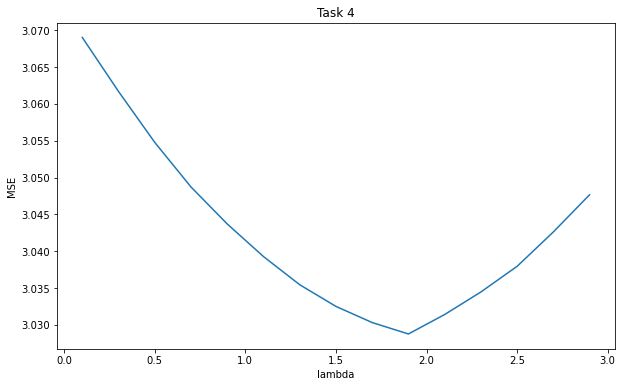

In [ ]:
X = data.drop("Sales", axis=1)
y = data["Sales"]
lambdas = np.arange(0.1, 3.0, 0.2)

lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    model = Lasso(alpha=val)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append(-np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')))


    
#plot diagram
plt.figure(figsize=(10, 6))
plt.plot(lambdas, lambda_errors)
plt.title('Task 4')
plt.ylabel('MSE')
plt.xlabel('lambda')
plt.show()

In [ ]:
y.shape

(200,)

**(0.5 балла) Обязательное задание 5:** Сделайте то же самое для L2-регуляризации:

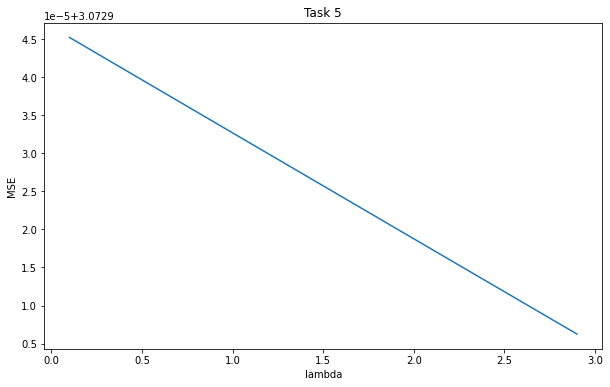

In [ ]:
X = data.drop("Sales", axis=1)
y = data["Sales"]
lambdas = np.arange(0.1, 3.0, 0.2)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    model = Ridge(alpha=val)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append(-np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')))


    
#plot diagram
plt.figure(figsize=(10, 6))
plt.plot(lambdas, lambda_errors)
plt.title('Task 5')
plt.ylabel('MSE')
plt.xlabel('lambda')
plt.show()

Если всё было правильно, то данные манипуляции помогут немного улучшить качество вашей модели. Это поднимет вас на несколько мест в соревнованиях, или вашему работодателю даст побольше прибыли.

### Основное домашнее задание (6 баллов + гешефт за улучшения)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

Для домашнего задания вы используете другой датасет.

In [ ]:
data = pd.read_csv('diabetes.data.csv', sep='\t')
data.head()

AGE  SEX   BMI     BP   S1     S2    S3   S4      S5  S6    Y
0   59    2  32.1  101.0  157   93.2  38.0  4.0  4.8598  87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.0  3.8918  69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.0  4.6728  85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.0  4.8903  89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.0  4.2905  80  135

В датасете приводится информация о пациентах и их состоянии при заболевании диабетом. Описание признаков можно прочитать [здесь](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html). Колонка Y - целевая переменная:

In [ ]:
target = 'Y'
X = data.drop([target], axis=1)
y = data[target]

X.shape, y.shape

((442, 10), (442,))

Ваша задача - провести то же исследование, что и в датасете в самом начале (Sales ~ TV, Radio, Newspaper). В итоге, нужно получить модель линейной регрессии, качество которой надо вывести с помощью cross_val_score с метрикой MSE (тоже самое в общем).

За каждое достойное улучшение качества на cross_val_score будут доп. баллы. Не забудьте описать, что использовали, что получилось и нет, а также попробуйте понять почему. Побольше гуглите. 

Возможные улучшения:
* Нормализация данных: вычитаем из каждой колонки её среднее и делим на её дисперсию.
* Пробуйте убрать ненужные признаки.
* Можно перемножать некоторые признаки.
* Погуглите что-то вроде "improve linear regression".

## Дефолтное решение

In [ ]:
model = LinearRegression()

print('result: ', -np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')))

result:  2993.081310469331


Получилось что-то такое, идем дальше


## Применим регуляризацию

In [ ]:
model = Lasso()

print('result for defolt Lasso: ', -np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')))

model = Ridge()

print('result for defolt Ridge: ', -np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')))

result for defolt Lasso:  3036.7597623128067
result for defolt Ridge:  2994.0434160839286


Еще хуже( Поиграемся с alpha

In [ ]:
lambdas = np.arange(0.1, 3.0, 0.2)
# Выведем доступные lambda
print("Все лямбды:")
print(lambdas)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    model = Lasso(alpha=val).fit(X, y)
    y_pred = model.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, -np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error'))))
    print(((val, -np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')))))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])

print(f'best alpha: {min_val} ,best MSE: {min_train_error}')

Все лямбды:
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
(0.1, 2993.8025348658416)
(0.30000000000000004, 2998.5942880689877)
(0.5000000000000001, 3007.925585445332)
(0.7000000000000001, 3017.3764479543192)
(0.9000000000000001, 3028.640275362544)
(1.1000000000000003, 3045.2052254212276)
(1.3000000000000003, 3063.2837925666513)
(1.5000000000000004, 3084.7454106334053)
(1.7000000000000004, 3109.2086674839607)
(1.9000000000000004, 3130.599744572518)
(2.1000000000000005, 3143.358933610379)
(2.3000000000000007, 3149.526568843901)
(2.5000000000000004, 3155.2742555119526)
(2.7000000000000006, 3160.719780913993)
(2.900000000000001, 3166.5451999548764)
best alpha: 0.1 ,best MSE: 2993.8025348658416


In [ ]:
lambdas = np.arange(0.1, 3.0, 0.2)
# Выведем доступные lambda
print("Все лямбды:")
print(lambdas)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    model = Ridge(alpha=val).fit(X, y)
    y_pred = model.predict(X)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, -np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error'))))
    print(((val, -np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')))))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])

print(f'best alpha: {min_val} ,best MSE: {min_train_error}')

Все лямбды:
[0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9 2.1 2.3 2.5 2.7 2.9]
(0.1, 2993.067553298013)
(0.30000000000000004, 2993.124197690104)
(0.5000000000000001, 2993.2819334738742)
(0.7000000000000001, 2993.5287960932656)
(0.9000000000000001, 2993.8542146791165)
(1.1000000000000003, 2994.2488351288307)
(1.3000000000000003, 2994.704367979155)
(1.5000000000000004, 2995.21345725094)
(1.7000000000000004, 2995.769567087601)
(1.9000000000000004, 2996.3668835347526)
(2.1000000000000005, 2997.0002292400145)
(2.3000000000000007, 2997.6649892074747)
(2.5000000000000004, 2998.357046035138)
(2.7000000000000006, 2999.0727233074467)
(2.900000000000001, 2999.8087360176805)
best alpha: 0.1 ,best MSE: 2993.067553298013


Все еще грустно. Теперь пробуем нормализовать данные

In [ ]:
from sklearn import preprocessing

data = pd.read_csv('diabetes.data.csv', sep='\t')

data = pd.DataFrame(data, columns = data.columns)
data.head()



AGE  SEX   BMI     BP   S1     S2    S3   S4      S5  S6    Y
0   59    2  32.1  101.0  157   93.2  38.0  4.0  4.8598  87  151
1   48    1  21.6   87.0  183  103.2  70.0  3.0  3.8918  69   75
2   72    2  30.5   93.0  156   93.6  41.0  4.0  4.6728  85  141
3   24    1  25.3   84.0  198  131.4  40.0  5.0  4.8903  89  206
4   50    1  23.0  101.0  192  125.4  52.0  4.0  4.2905  80  135

In [ ]:
target = 'Y'
X = preprocessing.scale(data.drop([target], axis=1), axis=0)
y = data[target]


In [ ]:
model = Lasso(alpha=0.1)

print('MSE: {}'.format(-np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error'))))

MSE: 2992.1728906721464


In [ ]:
corr = data.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:

model = Lasso(alpha=0.1)

print('MSE: {}'.format(-np.average(cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error'))))

model.fit(X, y).coef_

MSE: 2992.1728906721464


array([ -0.27769342, -11.15948797,  24.85518378,  15.2421328 ,
       -26.44813964,  13.72566329,  -0.        ,   7.05557447,
        31.57506171,   3.1584765 ])

## Пробую умножать признаки между собой

In [ ]:
from itertools import combinations
columns_list = data.drop([target], axis=1).columns
interactions = list(combinations(columns_list, 2))
interactions[0:5]

[('AGE', 'SEX'), ('AGE', 'BMI'), ('AGE', 'BP'), ('AGE', 'S1'), ('AGE', 'S2')]

In [ ]:
MSE_features = []
for interaction in interactions:
    X_df = pd.DataFrame(X, columns = columns_list)
    new_feature = X_df[interaction[0]] * X_df[interaction[1]]
    X_df.drop([interaction[0], interaction[1]], axis=1, inplace = True)
    X_df['new_feature'] = new_feature
    model = Lasso(alpha=0.1)
    
    MSE_features.append((-np.average(cross_val_score(model, X_df, y, cv=5, scoring='neg_mean_squared_error')), interaction))
best_features = sorted(MSE_features)[0]
best_features

(2912.6880508671825, ('S4', 'S6'))

Произведение фичи S4 и S6 дает неплохой прирост к точности нашей модели

In [ ]:
X_df = pd.DataFrame(X, columns = columns_list)
new_feature = X_df[best_features[1][0]] * X_df[best_features[1][1]]
X_df.drop([best_features[1][0], best_features[1][1]], axis=1, inplace = True)
X_df['S4 * S6'] = new_feature
X_df

AGE       SEX       BMI        BP        S1        S2        S3  \
0    0.800500  1.065488  1.297088  0.459841 -0.929746 -0.732065 -0.912451   
1   -0.039567 -0.938537 -1.082180 -0.553505 -0.177624 -0.402886  1.564414   
2    1.793307  1.065488  0.934533 -0.119214 -0.958674 -0.718897 -0.680245   
3   -1.872441 -0.938537 -0.243771 -0.770650  0.256292  0.525397 -0.757647   
4    0.113172 -0.938537 -0.764944  0.459841  0.082726  0.327890  0.171178   
..        ...       ...       ...       ...       ...       ...       ...   
437  0.876870  1.065488  0.413360  1.256040 -0.119769 -0.053957 -0.602843   
438 -0.115937  1.065488 -0.334410 -1.422086  1.037341  1.664355 -0.602843   
439  0.876870  1.065488 -0.334410  0.363573 -0.785107 -0.290965 -0.525441   
440 -0.956004 -0.938537  0.821235  0.025550  0.343075  0.321306 -0.602843   
441 -0.956004 -0.938537 -1.535374 -1.711613  1.760535  0.584649  3.654268   

           S5   S4 * S6  
0    0.418531  0.020219  
1   -1.436589  1.609521  
2    0.060156  0.029710  
3    0.476983 -0.141969  
4   -0.672502  0.053440  
..        ...       ...  
437  0.655787 -0.008257  
438 -0.380819  0.674601  
439 -0.985649 -0.075860  
440  0.936163 -0.304405  
441 -0.088752 -0.053493  

[442 rows x 9 columns]

## Используем полиномиальные фичи



In [ ]:
import warnings
warnings.filterwarnings('ignore')
results = []
for feature in X_df.columns:
    X_poly = X_df.copy()
    for i in range(2, 6):
        X_poly[feature] = np.power(X_poly[feature], i)

        model = Lasso(alpha=0.1)
        results.append((-np.average(cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error')), i, feature))
sorted(results)[0]


(2877.4707129967655, 3, 'AGE')

Возведя столбец AGE в 3ю степень мы получаем еще более низкий лос

### Теперь посмотрим на выбросы наших данных и почистим их
Заранее извиняюсь за такой формат боксов, почему-то не захотели сторится рядом в одной ячейке

In [ ]:
import seaborn as sns

<AxesSubplot:xlabel='Y'>

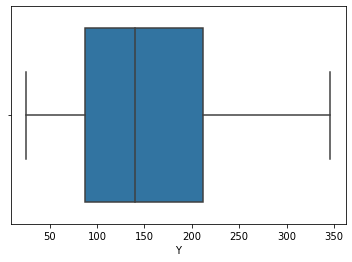

In [ ]:
sns.boxplot(data['Y'])

<AxesSubplot:xlabel='S1'>

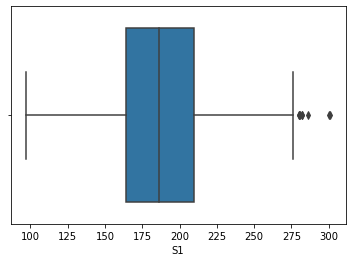

In [ ]:
sns.boxplot(data['S1'])

<AxesSubplot:xlabel='S2'>

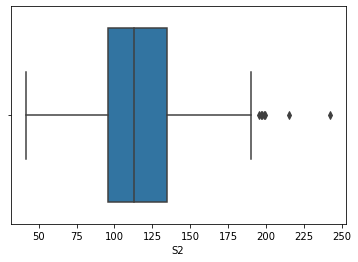

In [ ]:
sns.boxplot(data['S2'])

<AxesSubplot:xlabel='S3'>

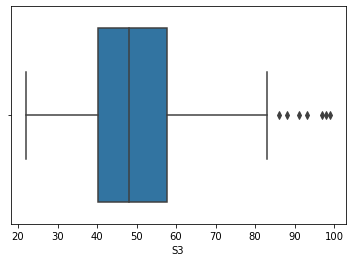

In [ ]:
sns.boxplot(data['S3'])

<AxesSubplot:xlabel='S4'>

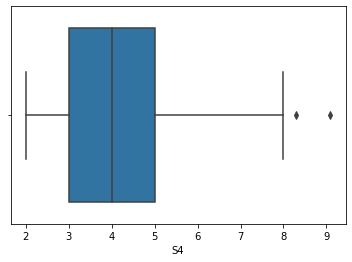

In [ ]:
sns.boxplot(data['S4'])

<AxesSubplot:xlabel='S5'>

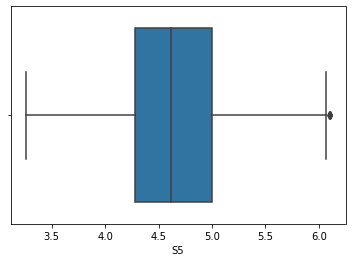

In [ ]:
sns.boxplot(data['S5'])

<AxesSubplot:xlabel='S6'>

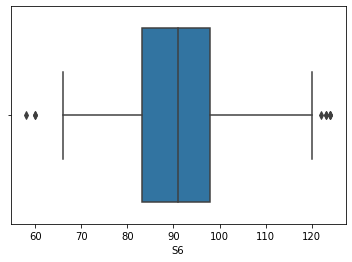

In [ ]:
sns.boxplot(data['S6'])

<AxesSubplot:xlabel='BMI'>

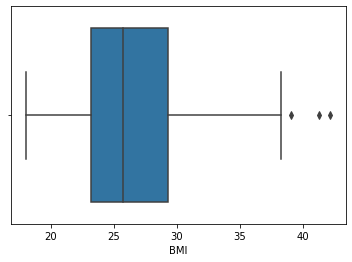

In [ ]:
sns.boxplot(data['BMI'])

<AxesSubplot:xlabel='BP'>

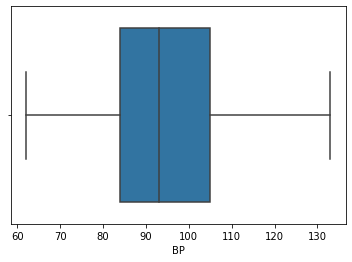

In [ ]:
sns.boxplot(data['BP'])

In [ ]:
data = pd.read_csv('diabetes.data.csv', sep='\t')
data.describe()

AGE         SEX         BMI          BP          S1          S2  \
count  442.000000  442.000000  442.000000  442.000000  442.000000  442.000000   
mean    48.518100    1.468326   26.375792   94.647014  189.140271  115.439140   
std     13.109028    0.499561    4.418122   13.831283   34.608052   30.413081   
min     19.000000    1.000000   18.000000   62.000000   97.000000   41.600000   
25%     38.250000    1.000000   23.200000   84.000000  164.250000   96.050000   
50%     50.000000    1.000000   25.700000   93.000000  186.000000  113.000000   
75%     59.000000    2.000000   29.275000  105.000000  209.750000  134.500000   
max     79.000000    2.000000   42.200000  133.000000  301.000000  242.400000   

               S3          S4          S5          S6           Y  
count  442.000000  442.000000  442.000000  442.000000  442.000000  
mean    49.788462    4.070249    4.641411   91.260181  152.133484  
std     12.934202    1.290450    0.522391   11.496335   77.093005  
min     22.000000    2.000000    3.258100   58.000000   25.000000  
25%     40.250000    3.000000    4.276700   83.250000   87.000000  
50%     48.000000    4.000000    4.620050   91.000000  140.500000  
75%     57.750000    5.000000    4.997200   98.000000  211.500000  
max     99.000000    9.090000    6.107000  124.000000  346.000000

## Чистим данные от выбросов

In [ ]:
for i in data.columns:
    IQR = data.describe().loc['75%', i] - data.describe().loc['25%', i]
    up = (1.5*IQR) + data.describe().loc['75%', i]
    dn = data.describe().loc['25%', i] - (1.5*IQR)
    data = data.loc[data[i] > dn]
    data = data.loc[data[i] < up]
data

AGE  SEX   BMI      BP   S1     S2    S3    S4      S5   S6    Y
0     59    2  32.1  101.00  157   93.2  38.0  4.00  4.8598   87  151
1     48    1  21.6   87.00  183  103.2  70.0  3.00  3.8918   69   75
2     72    2  30.5   93.00  156   93.6  41.0  4.00  4.6728   85  141
3     24    1  25.3   84.00  198  131.4  40.0  5.00  4.8903   89  206
4     50    1  23.0  101.00  192  125.4  52.0  4.00  4.2905   80  135
..   ...  ...   ...     ...  ...    ...   ...   ...     ...  ...  ...
436   33    1  19.5   80.00  171   85.4  75.0  2.00  3.9703   80   48
437   60    2  28.2  112.00  185  113.8  42.0  4.00  4.9836   93  178
438   47    2  24.9   75.00  225  166.0  42.0  5.00  4.4427  102  104
439   60    2  24.9   99.67  162  106.6  43.0  3.77  4.1271   95  132
440   36    1  30.0   95.00  201  125.2  42.0  4.79  5.1299   85  220

[405 rows x 11 columns]

Ошибка из 'коробки' стала меньше

In [ ]:
X_clear = preprocessing.scale(data.drop([target], axis=1), axis=0)
y_clear = data[target]

model = Lasso(alpha=0.1)
-np.average(cross_val_score(model, X_clear, y_clear, cv=5, scoring='neg_mean_squared_error'))

2981.3173449770866

## Теперь повторяю все те же действия что и раньше, но уже на чистых данных

In [ ]:
MSE_features = []
for interaction in interactions:
    X_df = pd.DataFrame(X_clear, columns = columns_list)
    new_feature = X_df[interaction[0]] * X_df[interaction[1]]
    X_df['new_feature'] = new_feature
    model = Lasso(alpha=0.1)
    
    MSE_features.append((-np.average(cross_val_score(model, X_df, y_clear, cv=5, scoring='neg_mean_squared_error')), interaction))
best_features = sorted(MSE_features)[0]
best_features

(2875.134914802763, ('BMI', 'BP'))

In [ ]:
X_df = pd.DataFrame(X_clear, columns = columns_list)
new_feature = X_df[best_features[1][0]] * X_df[best_features[1][1]]
X_df['BMI * BP'] = new_feature
X_df

AGE       SEX       BMI        BP        S1        S2        S3  \
0    0.803596  1.063757  1.391895  0.483780 -0.905116 -0.732209 -0.987836   
1   -0.027035 -0.940064 -1.090921 -0.550671 -0.075479 -0.369450  1.743334   
2    1.785251  1.063757  1.013561 -0.107335 -0.937025 -0.717699 -0.731789   
3   -1.839321 -0.940064 -0.216024 -0.772339  0.403158  0.653531 -0.817138   
4    0.123989 -0.940064 -0.759879  0.483780  0.211703  0.435875  0.207051   
..        ...       ...       ...       ...       ...       ...       ...   
400 -1.159714 -0.940064 -1.587484 -1.067896 -0.458388 -1.015161  2.170079   
401  0.879108  1.063757  0.469706  1.296562 -0.011661  0.015075 -0.646440   
402 -0.102547  1.063757 -0.310607 -1.437343  1.264704  1.908677 -0.646440   
403  0.879108  1.063757 -0.310607  0.385507 -0.745570 -0.246112 -0.561091   
404 -0.933178 -0.940064  0.895332  0.040444  0.498885  0.428620 -0.646440   

           S4        S5        S6  BMI * BP  
0    0.028495  0.538070 -0.347790  0.673371  
1   -0.842478 -1.447966 -2.031314  0.600738  
2    0.028495  0.154404 -0.534848 -0.108790  
3    0.899468  0.600646 -0.160732  0.166844  
4    0.028495 -0.629957 -1.002494 -0.367614  
..        ...       ...       ...       ...  
400 -1.713451 -1.286909 -1.002494  1.695268  
401  0.028495  0.792069  0.213385  0.609003  
402  0.899468 -0.317690  1.055147  0.446449  
403 -0.171829 -0.965204  0.400443 -0.119741  
404  0.716563  1.092231 -0.534848  0.036211  

[405 rows x 11 columns]

In [ ]:
results = []
for feature in X_df.columns:
    X_poly = X_df.copy()
    for i in range(2, 6):
        X_poly[feature] = np.power(X_poly[feature], i)

        model = Lasso(alpha=0.5)
        results.append((-np.average(cross_val_score(model, X_poly, y_clear, cv=5, scoring='neg_mean_squared_error')), i, feature))
sorted(results)[0]

(2823.546454953227, 2, 'S6')

In [ ]:
X_df['S6'] = np.power(X_df['S6'], 2)
X_df

AGE       SEX       BMI        BP        S1        S2        S3  \
0    0.803596  1.063757  1.391895  0.483780 -0.905116 -0.732209 -0.987836   
1   -0.027035 -0.940064 -1.090921 -0.550671 -0.075479 -0.369450  1.743334   
2    1.785251  1.063757  1.013561 -0.107335 -0.937025 -0.717699 -0.731789   
3   -1.839321 -0.940064 -0.216024 -0.772339  0.403158  0.653531 -0.817138   
4    0.123989 -0.940064 -0.759879  0.483780  0.211703  0.435875  0.207051   
..        ...       ...       ...       ...       ...       ...       ...   
400 -1.159714 -0.940064 -1.587484 -1.067896 -0.458388 -1.015161  2.170079   
401  0.879108  1.063757  0.469706  1.296562 -0.011661  0.015075 -0.646440   
402 -0.102547  1.063757 -0.310607 -1.437343  1.264704  1.908677 -0.646440   
403  0.879108  1.063757 -0.310607  0.385507 -0.745570 -0.246112 -0.561091   
404 -0.933178 -0.940064  0.895332  0.040444  0.498885  0.428620 -0.646440   

           S4        S5        S6  BMI * BP  
0    0.028495  0.538070  0.120958  0.673371  
1   -0.842478 -1.447966  4.126236  0.600738  
2    0.028495  0.154404  0.286062 -0.108790  
3    0.899468  0.600646  0.025835  0.166844  
4    0.028495 -0.629957  1.004993 -0.367614  
..        ...       ...       ...       ...  
400 -1.713451 -1.286909  1.004993  1.695268  
401  0.028495  0.792069  0.045533  0.609003  
402  0.899468 -0.317690  1.113335  0.446449  
403 -0.171829 -0.965204  0.160355 -0.119741  
404  0.716563  1.092231  0.286062  0.036211  

[405 rows x 11 columns]

In [ ]:
lambdas = np.arange(0.1, 3.0, 0.05)
# Выведем доступные lambda
print("Все лямбды:")
print(lambdas)

# Лямбды и их ошибки на обучающей выборке
lambda_errors = []

# Проходим по всем лямбдам и записываем ошибки на обучающей выборке
for val in lambdas:
    model = Lasso(alpha=val)
    # Сохраняем ошибку на обучающей выборке
    lambda_errors.append((val, -np.average(cross_val_score(model, X_df, y_clear, cv=5, scoring='neg_mean_squared_error'))))

min_val, min_train_error = min(lambda_errors, key=lambda x: x[1])

print(f'best alpha: {min_val} ,best MSE: {min_train_error}')

Все лямбды:
[0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45
 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15
 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85
 2.9  2.95]
best alpha: 0.6000000000000002 ,best MSE: 2823.4066772407273


## Стало немного лучше. Итоговый MSE 2823.4

В общем, представьте, что вы работаете датасаентистом, получаете 300к долларов, а вам сказали, что нужно как можно лучше уметь предсказывать такие данные.